In [168]:
%matplotlib inline
import matplotlib.pyplot as plt
import gensim
from Bio import SeqIO
import numpy as np
from numpy import linalg as LA
from collections import UserDict
from sklearn import preprocessing
from functools import reduce
from operator import add
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from pepdata import amino_acid
from sklearn.manifold import TSNE
from random import choice
from sklearn import model_selection
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from glob import glob
import itertools

In [2]:
def make_ngrams(seq, n, shift=True):
    res = []
    if shift:
        for i in range(n):
            res.append(list(map(''.join, (zip(*[iter(seq[i:])]*n)))))
    else:
        res.append(list(map(''.join, (zip(*[iter(seq)]*n)))))
    
    return res

In [3]:
def process_fasta(fname, n, shift=True):
    res = []
    fd = SeqIO.parse(fname, "fasta")
    for r in fd:
        res += make_ngrams(r, n, shift)
    
    return res

In [4]:
def read_embeddings(filename):
    res = UserDict()
    f = open(filename)
    v_size, e_size = [int(i.strip()) for i in f.readline().split()]
    for l in f.readlines():
        l = l.split()
        w = l[0]
        v = np.array([float(i) for i in l[1:]])
        res[w] = v
    res.wsize = len(w)
    return res

In [116]:
def make_pep_vector(sequence, emb, shift=True):
    ngrams = make_ngrams(sequence, emb.wsize, shift=shift)
    ngrams = reduce(add, ngrams)
    ngrams = [ng for ng in ngrams if ng in emb.keys()]
    res = sum([emb[n] for n in ngrams])
    res = res/LA.norm(res)
    return res

In [117]:
#ng, vec = zip(*[(x, y) for x, y in emb.items()])

In [118]:
def prop(x, method = amino_acid.hydropathy):
    try:
        return method(x)
    except:
        return 0

In [256]:
def pepcls(peps1, peps2, emb, sne=True):
    v1 = list(map(lambda s: make_pep_vector(s, emb), peps1))
    v2 = list(map(lambda s: make_pep_vector(s, emb), peps2))
    all_vec = v1+v2
    truey = [0]*len(v1)+[1]*len(v2)
    if sne:
        tsne = TSNE(n_components=2)
        tsne = tsne.fit_transform(all_vec)
        plt.scatter(tsne[:, 0], tsne[:,1], c= truey, s=2)
        plt.show()
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(all_vec, truey)
    mod = RandomForestClassifier(n_estimators=1000)
    
    mod.fit(X_train, y_train)
    print("Score: ", mod.score(X_test, y_test))
    print("P_R_F: ", precision_recall_fscore_support(y_test, mod.predict(X_test),average="binary"))
    return mod

## Actual processing ##

In [206]:
emb_o = read_embeddings("model_neg20_w3_1000it_hs0_sg1_w2v")

In [207]:
#emb_o = read_embeddings("protVec_100d_3grams.csv")

In [208]:
pos = [l.strip() for l in open("amps/Whole_pos_antiBP2.data")]

In [209]:
neg = [l.strip() for l in open("amps/Whole_neg_antiBP2.data")]

In [210]:
len(pos), len(neg)

(999, 999)

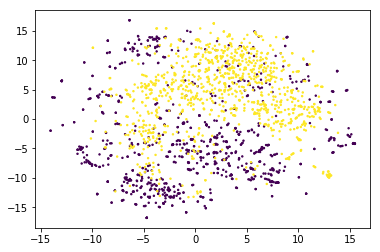

Score:  0.882
P_R_F:  (0.8828125, 0.88627450980392153, 0.8845401174168297, None)


In [257]:
mod = pepcls(pos, neg, emb_o)

In [258]:
pep102 = [str(l.seq) for l in SeqIO.parse("amps/102_Bactria_peptides_validated_2017.08.31_short.txt", "fasta")]

In [259]:
rnd4 = [l.strip() for l in open("amps/peps_rand4.txt")]

In [260]:
pep102_v = [make_pep_vector(p, emb_o) for p in pep102]
rnd4_v = [make_pep_vector(p, emb_o) for p in rnd4]


In [263]:
mod.predict_proba(pep102_v)[:,0], mod.predict_proba(rnd4_v)[:,0], \
sum(mod.predict_proba(pep102_v)[:,0]>0.6), sum(mod.predict_proba(rnd4_v)[:,0]>0.6)

(array([ 0.301,  0.284,  0.42 ,  0.479,  0.335,  0.532,  0.407,  0.245,
         0.374,  0.297,  0.153,  0.35 ,  0.62 ,  0.29 ,  0.373,  0.566,
         0.523,  0.533,  0.513,  0.491,  0.654,  0.338,  0.459,  0.214,
         0.413,  0.56 ,  0.301,  0.496,  0.279,  0.666,  0.393,  0.115,
         0.584,  0.295,  0.432,  0.454,  0.423,  0.449,  0.295,  0.535,
         0.542,  0.406,  0.476,  0.327,  0.584,  0.488,  0.473,  0.61 ,
         0.364,  0.396,  0.246,  0.492,  0.544,  0.707,  0.312,  0.455,
         0.519,  0.419,  0.334,  0.364,  0.353,  0.499,  0.355,  0.573,
         0.427,  0.367,  0.549,  0.369,  0.402,  0.368,  0.454,  0.408,
         0.469,  0.403,  0.339,  0.325,  0.412,  0.317,  0.383,  0.56 ,
         0.447,  0.467,  0.194,  0.538,  0.626,  0.357,  0.513,  0.553,
         0.274,  0.352,  0.31 ,  0.534,  0.602,  0.373,  0.435,  0.353,
         0.435,  0.528,  0.421,  0.483,  0.408,  0.359]),
 array([ 0.485,  0.596,  0.473,  0.304,  0.386,  0.334,  0.224,  0.472,
      

In [271]:
spos = [choice(pos) for x in range(102)]
sneg = [choice(neg) for x in range(102)]
spos_v = [make_pep_vector(p, emb_o) for p in spos]
sneg_v = [make_pep_vector(p, emb_o) for p in sneg]
mod.predict_proba(spos_v)[:,0], mod.predict_proba(sneg_v)[:,0], \
sum(mod.predict_proba(spos_v)[:,0]>0.6), sum(mod.predict_proba(sneg_v)[:,0]>0.6)

(array([ 0.896,  0.959,  0.887,  0.921,  0.86 ,  0.947,  0.862,  0.603,
         0.765,  0.594,  0.912,  0.899,  0.782,  0.818,  0.543,  0.657,
         0.693,  0.919,  0.957,  0.914,  0.762,  0.965,  0.974,  0.808,
         0.912,  0.801,  0.724,  0.659,  0.944,  0.613,  0.949,  0.954,
         0.805,  0.785,  0.953,  0.943,  0.747,  0.427,  0.841,  0.94 ,
         0.909,  0.93 ,  0.786,  0.832,  0.964,  0.92 ,  0.282,  0.891,
         0.937,  0.797,  0.906,  0.817,  0.985,  0.891,  0.839,  0.675,
         0.953,  0.925,  0.962,  0.912,  0.935,  0.808,  0.934,  0.85 ,
         0.971,  0.96 ,  0.872,  0.627,  0.986,  0.88 ,  0.872,  0.939,
         0.974,  0.905,  0.728,  0.955,  0.949,  0.739,  0.946,  0.795,
         0.881,  0.889,  0.941,  0.904,  0.957,  0.84 ,  0.7  ,  0.953,
         0.92 ,  0.923,  0.883,  0.924,  0.952,  0.843,  0.472,  0.975,
         0.952,  0.842,  0.922,  0.953,  0.909,  0.778]),
 array([ 0.172,  0.33 ,  0.133,  0.077,  0.136,  0.094,  0.027,  0.179,
      

In [278]:
ok102 = list(itertools.compress(pep102, mod.predict_proba([make_pep_vector(p, emb_o) for p in pep102])[:,0]>0.5))

name_map = {str(r.seq):str(r.name) for r in SeqIO.parse("amps/102_Bactria_peptides_validated_2017.08.31_cp.fasta", "fasta")}

{name_map[s] : s for s in ok102}

{'Peptide_024': 'GVGEDISDGGNAISGAATK',
 'Peptide_031': 'KNEVKAKNIDILE',
 'Peptide_034': 'ILLINPTDSDAVGNAVK',
 'Peptide_035': 'AIAQVGTISANSDETVGK',
 'Peptide_038': 'VGEEVEIVGIK',
 'Peptide_039': 'VGLTALTMAEYFR',
 'Peptide_044': 'ANILPVIGTPHV',
 'Peptide_054': 'TLKEVGATVILLS',
 'Peptide_059': 'DAIKQVIDKFGE',
 'Peptide_065': 'RIAIIMAAIGL',
 'Peptide_080': 'NGVCLTVTDLGED',
 'Peptide_081': 'VIELQGIAGTSAAR',
 'Peptide_091': 'MQLSNLYIVPM',
 'Peptide_096': 'VTAIGIGIAID',
 'Peptide_108': 'KVGTYSTFTLLD',
 'Peptide_109': 'PLTVICNGKAH',
 'Peptide_112': 'ITTLWMPEV',
 'Peptide_120': 'HDKMEIVLVD',
 'Peptide_126': 'PITGPYVIVGH',
 'Peptide_153': 'TNIKINPLIINS',
 'Peptide_161': 'TLMIDKMPV',
 'Peptide_164': 'PITVIDTKNIG',
 'Peptide_214': 'IEEVKQGILNEEL',
 'Peptide_216': 'PVEYMKVL',
 'Peptide_227': 'LSALVAGLIDA',
 'Peptide_228': 'PAGVYTVKYKF',
 'Peptide_245': 'VTASVAGGEKEAKEIL'}